In [1]:
import ast
import glob
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
from torchvision.io.image import read_image
from torchvision import transforms
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask

In [2]:
# Define constants
_ANIMAL_CLASS_FILE = 'animal_classes.txt'
_DATA_PATH = '../data/train_simplified'
_IMAGE_SIZE = 224
_TRAIN_ROWS_PER_CLASS = 22500
_TEST_ROWS_PER_CLASS = 7500
_DATALOADER_BATCH_SIZE = 256
_DATALOADER_NUM_WORKERS = 4
_MODEL_NAME = 'model_v11_efficientnetb3'
_MODEL_CHECKPOINT = '../models/checkpoint_v11_efficientnetb3.pth'

In [3]:
class DoodlesDataset(Dataset):
    """Custom class for the Quick! Draw It doodles dataset"""

    # Class variable of doodle image default size
    doodle_base_size = 256

    def __init__(self, csv_file, root_dir, encoding_dict, num_rows=1000, skip_rows=None, size=256, transform=None):
        """
        Args:
            csv_file(str): Path to the CSV file containing doodle data
            root_dir(str): Path to root directory containing all the doodles data files
            num_rows(int): Number of rows of the CSV file to read
            skip_rows(int): Number of rows to skip from the beginning of the CSV file
            size(int): Size of output image
            transform(torchvision.transforms): Torchvision transformations to be applied on a doodle, defaults to None
        """
        self.root_dir = root_dir
        self.size = size
        self.doodle = pd.read_csv(os.path.join(self.root_dir, csv_file), usecols=['drawing'], nrows=num_rows, skiprows=skip_rows)
        self.transform = transform
        self.label = get_label(encoding_dict, csv_file)


    @staticmethod
    def _draw(raw_strokes, size=256, line_weight=6, time_color=False):
        """
        Draws the doodle using OpenCV line function and resizes it to specified size if necessary.

        Args:
            raw_strokes(List[List[List[int], List[int]]]: Nested lists representing doodle strokes in sequence, where the outermost list represent a stroke, the first innermost list represents X displacement of each point, and the second innermost list represents Y displacement of each point
            size(int): Size of the doodle to be drawn
            line_weight(int): Size of the line
            time_color(bool): Shows stroke of varying color as a function of time, defaults to False

        Returns:
            img(np.ndarray): Numpy array representing the doodle
        """
        # Initialize doodle as empty numpy matrix
        img = np.zeros((DoodlesDataset.doodle_base_size, DoodlesDataset.doodle_base_size), np.uint8)

        # Draw doodle according to sequence of strokes
        for t, stroke in enumerate(raw_strokes):
            for i in range(len(stroke[0]) - 1):
                color = 255 - min(t, 10) * 13 if time_color else 255
                _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                             (stroke[0][i + 1], stroke[1][i + 1]), color, line_weight)
        
        # Resize doodle if applicable
        if size != DoodlesDataset.doodle_base_size:
            img = cv2.resize(img, (size, size))
        
        return img
    

    def __len__(self):
        """Returns size of the dataset"""
        return len(self.doodle)


    def __getitem__(self, index):
        """
        Gets one doodle and its label by index.

        Args:
            index(int): Index representing target row in doodle dataset to access
        
        Returns:        
            (np.ndarray): Numpy array representing the doodle
            (int): Numerically encoded label of the doodle
        """
        # Perform literal evaluation of string to obtain raw strokes
        raw_strokes = ast.literal_eval(self.doodle.drawing[index])

        # Call static draw method to get doodle drawn
        doodle = self._draw(raw_strokes, size=self.size, line_weight=2)

        # Apply transformations on doodle if applicable
        if self.transform:
            doodle = self.transform(doodle)
        
        return (doodle[None]/255).astype('float32'), self.label


def decode_labels(dec_dict, label):
    """
    Obtains the class label (string) represented by the given numerically encoded label.

    Args:
        dec_dict(dict[int, str]): Dictionary containing the numerically encoded label and their corresponding class label
        label(int): Numerical encoded label 

    Returns:
        (str): Class label corresponding to the encoded label
    """
    return dec_dict[label]


def get_label(encoding_dict, filename):
    """
    Obtains the numerically encoded label of a class given a CSV file of doodle data.

    Args:
        encoding_dict(dict[str, int]): Dictionary containing the class label and their corresponding numerically encoded label
        filename(str): Path to a CSV file containing doodle data
    
    Returns:
        (int): Numerically encoded label of a class
    """
    return encoding_dict[filename[:-4].split('/')[-1].replace(' ', '_')]

In [4]:
def load_classes(filename):
    """
    Loads the class labels from a text file.
    
    Args:
        filename(str): Path to the text file containing class labels

    Returns:
        classes(List[str]): List containing all class labels
    """
    with open(filename, 'r') as f:
        classes = f.read()
    return classes.split("\n")

In [5]:
def prepare_data(animal_list):
    """
    Prepares dataset as dataloaders and adds transformations to them.

    Args:
        animal_list(List[str]): List containing all class labels

    Returns:
        encoding_dict(dict[str, int]): Dictionary containing the class label and their corresponding encoding number 
        dataloaders(dict[str, torch.utils.data.DataLoader]): Dictionary containing the train and test dataloaders
        dataset_sizes(dict[str, int]): Dictionary containing the sizes of train and test datasets
    """
    # Get all the CSV files containing doodle data
    filenames = glob.glob(os.path.join(_DATA_PATH, '*.csv'))

    # Filter classes to only those in animal_list
    filtered_filenames = []
    for file in filenames:
        if file.split('/')[-1].split('.')[0].replace(' ', '_') in animal_list:
            filtered_filenames.append(file)
    
    # Initialize dictionary to encode label with numbers
    encoding_dict = {}
    counter = 0
    for fn in filtered_filenames:
        encoding_dict[fn[:-4].split('/')[-1].replace(' ', '_')] = counter
        counter += 1
    
    # Create an inverted dictionary for decoding number to label
    decoding_dict = {v: k for k , v in encoding_dict.items()}
    
    # Create train set by concatenating dataset from all classes
#     train_set = ConcatDataset([DoodlesDataset(fn.split('/')[-1], _DATA_PATH, encoding_dict, num_rows=_TRAIN_ROWS_PER_CLASS, size=_IMAGE_SIZE) for fn in filtered_filenames])
    
    # Create test set by concatenating dataset from all classes
    test_set = ConcatDataset([DoodlesDataset(fn.split('/')[-1], _DATA_PATH, encoding_dict, num_rows=_TEST_ROWS_PER_CLASS, size=_IMAGE_SIZE, skip_rows=range(1, _TRAIN_ROWS_PER_CLASS+1)) for fn in filtered_filenames])

    # Prepare data transformations
    data_transforms = {
        'test': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5],std=[0.5])
        ])
    }

    # Assign data transformations to train and test datasets    
#     train_set.transforms = data_transforms['train']
    test_set.transforms = data_transforms['test']
    
    # Create dataloaders from train and test datasets
#     train_loader = DataLoader(train_set, batch_size=_DATALOADER_BATCH_SIZE, shuffle=True, num_workers=_DATALOADER_NUM_WORKERS)
    test_loader = DataLoader(test_set, batch_size=_DATALOADER_BATCH_SIZE, shuffle=False, num_workers=_DATALOADER_NUM_WORKERS)

    # Set up dictionary for dataloaders
    dataloaders = {'test': test_loader}

    # Store size of training and test sets in a dictionary
    dataset_sizes = {'test': len(test_set)}

    return encoding_dict, decoding_dict, dataloaders, dataset_sizes

In [6]:
def load_model(model_weights, num_classes, device):
    """
    Loads a trained PyTorch EfficientNet B3 model.

    Args:
        model_weights(str): Path to the pickled state_dict of a PyTorch EfficientNet B3 model containing its trained weights
        num_classes(int): Number of classes in the final linear layer
        device(str):  Name of device where model weights reside, e.g. 'cuda', 'cpu'

    Returns:
        torch_model(torch.nn.Module): A PyTorch EfficientNet B3 model
    """
    # Load pre-trained EfficientNet B3 model
    model = torchvision.models.efficientnet_b3(weights='DEFAULT')

    # Change number of input channel to 1 and squeeze first layer weights
    model.features[0][0].in_channels = 1
    model.features[0][0].weight.data = model.features[0][0].weight.data.sum(dim=1)[:,None]

    # Change the number of output classes in final layer
    fc_in_features = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(in_features=fc_in_features, out_features=num_classes)

    # Load weights from trained model
    model.load_state_dict(torch.load(model_weights, map_location=torch.device(device)))

    return model

In [7]:
# Load classes
animal_list = load_classes(_ANIMAL_CLASS_FILE)

In [ ]:
# Prepare data
encoding_dict, decoding_dict, dataloaders, dataset_sizes = prepare_data(animal_list)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load trained model onto device
model = load_model(_MODEL_CHECKPOINT, len(animal_list), device)
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [11]:
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Conv2d):
        print(name, layer)

features.0.0 Conv2d(1, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
features.1.0.block.0.0 Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
features.1.0.block.1.fc1 Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
features.1.0.block.1.fc2 Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
features.1.0.block.2.0 Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
features.1.1.block.0.0 Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24, bias=False)
features.1.1.block.1.fc1 Conv2d(24, 6, kernel_size=(1, 1), stride=(1, 1))
features.1.1.block.1.fc2 Conv2d(6, 24, kernel_size=(1, 1), stride=(1, 1))
features.1.1.block.2.0 Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
features.2.0.block.0.0 Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
features.2.0.block.1.0 Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=144, bias=False)
features.2.0.bloc

In [12]:
# Setup the CAM extractor
model.eval()
cam_extractor = SmoothGradCAMpp(model, 'features.8.0')

In [31]:
img = read_image("test_cat_1.png")
img = img[1,:,:]
img.shape

torch.Size([884, 892])

In [32]:
img = cv2.resize(img.cpu().numpy(), (224, 224))
print(img.shape)
img = img[None]
input_tensor = normalize(torch.Tensor(img) / 255., [0.5], [0.5])
print(input_tensor.shape)
input_tensor = input_tensor.to(device)
# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

(224, 224)
torch.Size([1, 224, 224])


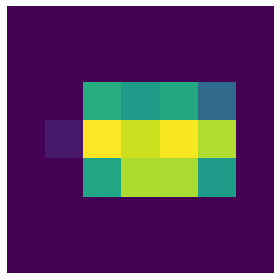

In [34]:
# Visualize the raw CAM
plt.imshow(activation_map[0].squeeze(0).cpu().numpy())
plt.axis('off')
plt.tight_layout()
plt.show()

torch.Size([3, 884, 892])


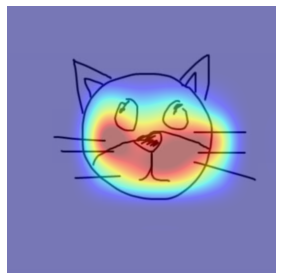

In [46]:
# Resize the CAM and overlay it
img = read_image("test_cat_1.png")
img = img[:3, ...]
# img = img[1,:,:]
# img = img[:, :, None]
print(img.shape)
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0).cpu(), mode='F'), alpha=0.5)
# Display it
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()
plt.imsave(f'test_cat_1_cam.png', result)

(224, 224)
torch.Size([1, 224, 224])


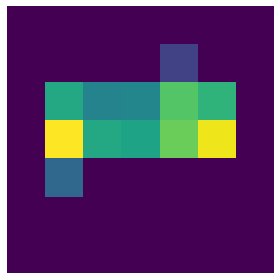

In [47]:
img = read_image("test_dog_1.png")
img = img[1,:,:]
# img = img[None]
img.shape
# img = read_image("test_cat_1.png")
# Preprocess it for your chosen model
img = cv2.resize(img.cpu().numpy(), (224, 224))
print(img.shape)
img = img[None]
input_tensor = normalize(torch.Tensor(img) / 255., [0.5], [0.5])
print(input_tensor.shape)
input_tensor = input_tensor.to(device)
# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
# Visualize the raw CAM
plt.imshow(activation_map[0].squeeze(0).cpu().numpy())
plt.axis('off')
plt.tight_layout()
plt.show()

torch.Size([3, 566, 634])


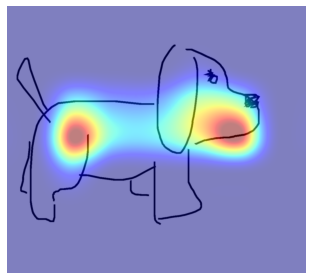

In [48]:
# Resize the CAM and overlay it
img = read_image("test_dog_1.png")
img = img[:3, ...]
# img = img[1,:,:]
# img = img[:, :, None]
print(img.shape)
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0).cpu(), mode='F'), alpha=0.5)
# Display it
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()
plt.imsave(f'test_dog_1_cam.png', result)

(224, 224)
torch.Size([1, 224, 224])


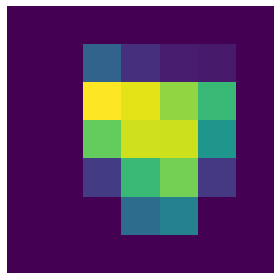

In [51]:
img = read_image("test_teddybear_1.png")
img = img[1,:,:]
# img = img[None]
img.shape
# img = read_image("test_cat_1.png")
# Preprocess it for your chosen model
img = cv2.resize(img.cpu().numpy(), (224, 224))
print(img.shape)
img = img[None]
input_tensor = normalize(torch.Tensor(img) / 255., [0.5], [0.5])
print(input_tensor.shape)
input_tensor = input_tensor.to(device)
# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
# Visualize the raw CAM
plt.imshow(activation_map[0].squeeze(0).cpu().numpy())
plt.axis('off')
plt.tight_layout()
plt.show()

torch.Size([3, 688, 608])


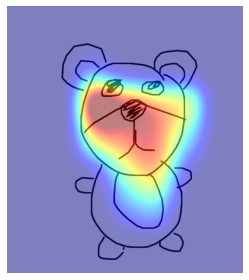

In [52]:
# Resize the CAM and overlay it
img = read_image("test_teddybear_1.png")
img = img[:3, ...]
# img = img[1,:,:]
# img = img[:, :, None]
print(img.shape)
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0).cpu(), mode='F'), alpha=0.5)
# Display it
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()
# plt.imsave(f'test_dog_1_cam.png', result)

(224, 224)
torch.Size([1, 224, 224])


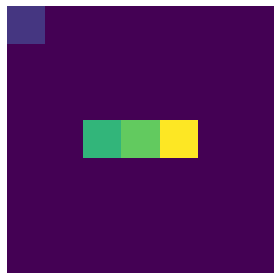

In [53]:
img = read_image("test_fish_ios.png")
img = img[1,:,:]
# img = img[None]
img.shape
# img = read_image("test_cat_1.png")
# Preprocess it for your chosen model
img = cv2.resize(img.cpu().numpy(), (224, 224))
print(img.shape)
img = img[None]
input_tensor = normalize(torch.Tensor(img) / 255., [0.5], [0.5])
print(input_tensor.shape)
input_tensor = input_tensor.to(device)
# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
# Visualize the raw CAM
plt.imshow(activation_map[0].squeeze(0).cpu().numpy())
plt.axis('off')
plt.tight_layout()
plt.show()

torch.Size([3, 633, 685])


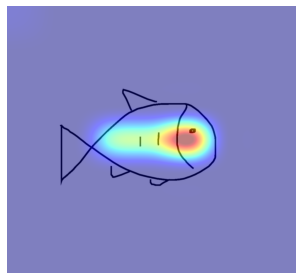

In [54]:
# Resize the CAM and overlay it
img = read_image("test_fish_ios.png")
img = img[:3, ...]
# img = img[1,:,:]
# img = img[:, :, None]
print(img.shape)
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0).cpu(), mode='F'), alpha=0.5)
# Display it
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()
# plt.imsave(f'test_dog_1_cam.png', result)

torch.Size([16, 1, 224, 224])
torch.Size([16])
tensor([40, 26, 43, 39, 35, 35, 35, 38,  9, 17,  0, 18, 13, 12, 27, 19])


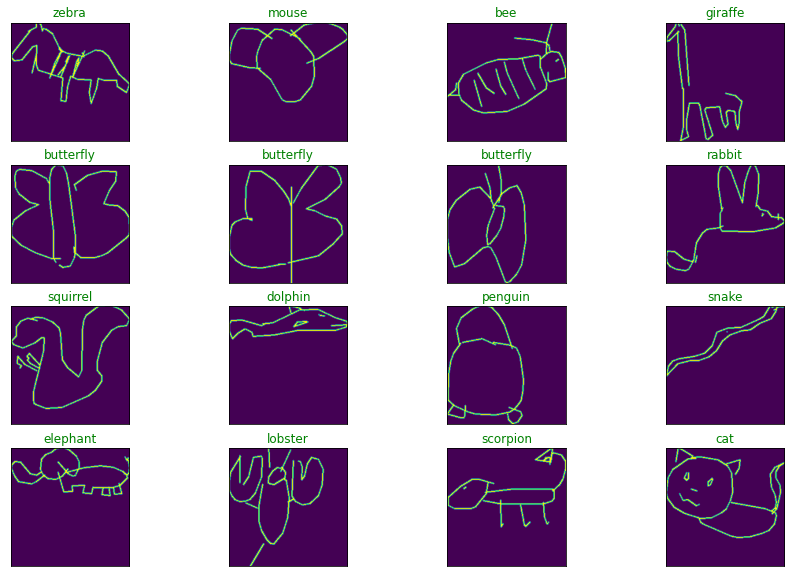

In [8]:
# Plot doodles
images, labels = next(iter(dataloaders['train']))
print(images.shape)
print(labels.shape)
print(labels.data)

fig = plt.figure(figsize=(15, 10))
for idx in np.arange(_DATALOADER_BATCH_SIZE):
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
    image = images[idx]
    ax.imshow(np.squeeze(image))
    ax.set_title("{}".format(decode_labels(decoding_dict, labels[idx].item())),
                color="green")